In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import tensorflow as tf

In [16]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import zipfile

In [3]:
local_weights_file = '/data/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O $local_weights_file

--2019-11-20 20:45:46--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.193.128, 2a00:1450:400b:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/data/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/data/tmp/inception 100%[===================>]  83.84M  22.2MB/s    in 3.8s    

2019-11-20 20:45:50 (21.8 MB/s) - ‘/data/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [4]:
# Define the model with Inception
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, # do not include first fully connected layer 
                                weights = None)

In [5]:
# Load Weights (snapshot) to be used instead of built-in ones
pre_trained_model.load_weights(local_weights_file)


In [6]:
# Lock all the layers from the pre trained model 
for layer in pre_trained_model.layers:
  layer.trainable = False

In [7]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
#Take the layer you want to start from 
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
# Take the output from the layer
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [9]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

In [10]:
# Define the model with the input from the pre-trained model 
# and the output 
model = Model( pre_trained_model.input, x) 

'''
Configure the model with: 
- Optimizer: RMSprop
- Loss: Binary Crossentropy
'''
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
local_zip = '/data/tmp/cats_and_dogs_filtered.zip'

!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O $local_zip

--2019-11-10 17:24:22--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.193.128, 2a00:1450:400b:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/data/tmp/cats_and_dogs_filtered.zip’

/data/tmp/cats_and_ 100%[===================>]  65.43M  21.4MB/s    in 3.1s    

2019-11-10 17:24:26 (21.4 MB/s) - ‘/data/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [10]:
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [12]:
# Define our example directories and files
base_dir = '/data/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [13]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

Found 2000 images belonging to 2 classes.


In [14]:
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 1000 images belonging to 2 classes.


In [15]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 33s - loss: 0.5044 - acc: 0.7560 - val_loss: 0.1449 - val_acc: 0.9510
Epoch 2/20
100/100 - 29s - loss: 0.3737 - acc: 0.8405 - val_loss: 0.2915 - val_acc: 0.9290
Epoch 3/20
100/100 - 29s - loss: 0.3543 - acc: 0.8425 - val_loss: 0.4342 - val_acc: 0.9100
Epoch 4/20
100/100 - 30s - loss: 0.3307 - acc: 0.8555 - val_loss: 0.1919 - val_acc: 0.9550
Epoch 5/20
100/100 - 31s - loss: 0.3274 - acc: 0.8520 - val_loss: 0.2468 - val_acc: 0.9520
Epoch 6/20
100/100 - 29s - loss: 0.2923 - acc: 0.8895 - val_loss: 0.2917 - val_acc: 0.9500
Epoch 7/20
100/100 - 29s - loss: 0.3190 - acc: 0.8565 - val_loss: 0.3028 - val_acc: 0.9430
Epoch 8/20
100/100 - 31s - loss: 0.3094 - acc: 0.8695 - val_loss: 0.2594 - val_acc: 0.9530
Epoch 9/20
100/100 - 32s - loss: 0.2924 - acc: 0.8885 - val_loss: 0.2419 - val_acc: 0.9620
Epoch 10/20
100/100 - 31s - loss: 0.2828 - acc: 0.8900 - val_loss: 0.2810 - val_acc: 0.9570
Epoch 11/20
100/100 - 29s - loss: 0.2799 - acc: 0.8885 - val_loss: 0.5596 - val_acc: 0.92

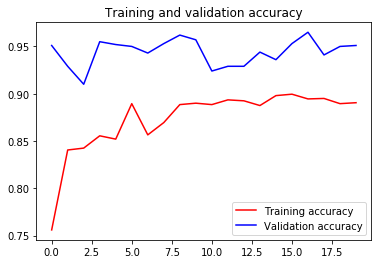

<Figure size 432x288 with 0 Axes>

In [17]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()